In [14]:
import numpy as np
import torch
import cv2
import importlib
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
from tool import imutils
import voc12.data

In [15]:
def visualize(normalized_heatmap, original=None):
    map_img = np.uint8(normalized_heatmap * 255)
    heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
    if original is not None:
        original_img = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
        img = cv2.addWeighted(heatmap_img, .6, original_img, 0.4, 0)
    else:
        img = heatmap_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    axes.imshow(img)
    plt.show()

In [16]:
model = getattr(importlib.import_module('network.conformer_CAM'), 'Net_sm')()
model.load_state_dict(torch.load('transcam_6485.pth'))
model = model.cuda()
model.eval()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    np.asarray,
    imutils.Normalize(),
    imutils.HWC_to_CHW,
    torch.from_numpy
])

In [17]:
voc12_root = 'VOCdevkit/VOC2012'

In [18]:
def visualize_img(name, label):
    img_path = voc12.data.get_img_path(name, voc12_root)
    orig_img = np.asarray(Image.open(img_path))
    orig_img_size = orig_img.shape[:2]
    img = transform(Image.open(img_path))
    _, _, cams = model('transcam', img.unsqueeze(0).cuda())
    cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False).detach()
    cams = cams.cpu().numpy()[0][1:]
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min) / (cam_max - cam_min + 1e-5)
    cam = norm_cam[label]
    visualize(cam, orig_img)

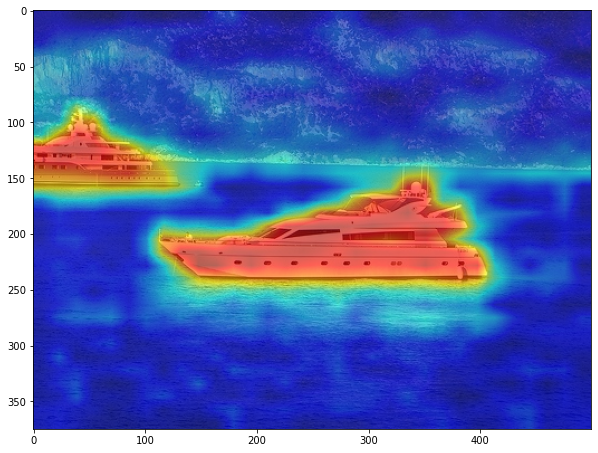

In [19]:
img_name_1 = '2007_002234'
img_label_1 = 3
visualize_img(img_name_1, img_label_1)

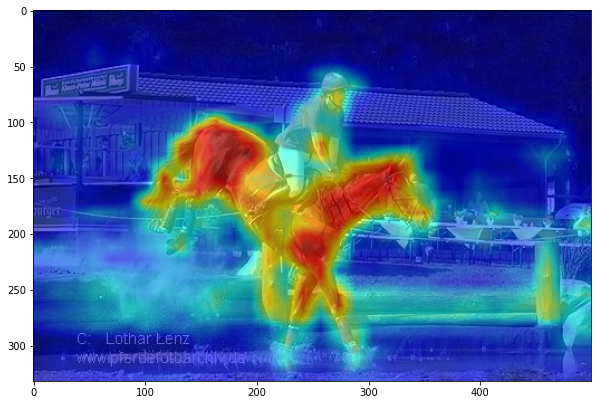

In [20]:
img_name_1 = '2007_000392'
img_label_1 = 12
visualize_img(img_name_1, img_label_1)

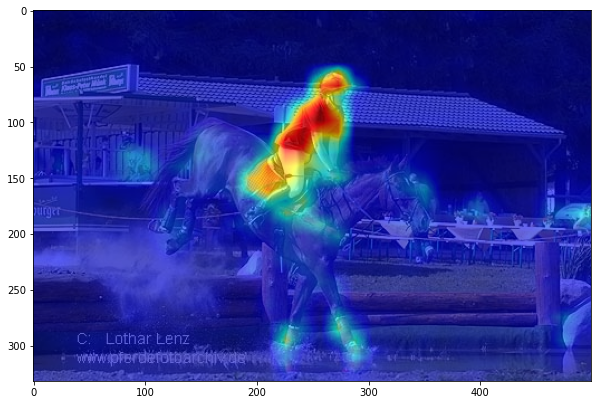

In [21]:
img_name_1 = '2007_000392'
img_label_1 = 14
visualize_img(img_name_1, img_label_1)